# Time series analysis

<div>
<img src="https://openai-labs-public-images-prod.azureedge.net/user-gpqnb8wYDKtLhvV75f1v5rKy/generations/generation-gdRXcF5Ihr2nJH9Z23Y7qCjG/image.png" width="300"/>
</div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Library om YouTube videos te importeren 

from IPython.display import YouTubeVideo, Image

## 1 What is a time series?

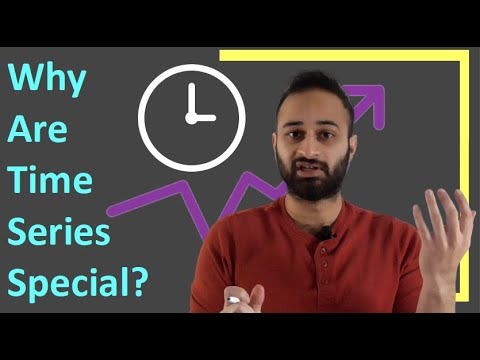

In [3]:
YouTubeVideo("ZoJ2OctrFLA", width=800, height=500)

A time series is a sequence of data points collected at regular intervals of time. It is a set of data that is ordered in time and is used to study trends, patterns, and relationships over time. Time series data can be collected for various variables, such as stock prices, economic indicators, weather data, and many others. Time series analysis involves the use of statistical and mathematical methods to model, forecast, and analyze these data over time. The goal is to identify trends, patterns, and relationships that can be used to make predictions or draw inferences about future behavior.

Note: An excellent series of videos on time series analysis can be found at this [playlist](https://www.youtube.com/playlist?list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3). The first video from this playlist has been embedded above in the notebook. It is worth watching this playlist if you have a day to spare (it is almost 8 hours long). In this notebook we will just go over a few examples of time series data and their analyses.

An example of a time series dataset is shown below:

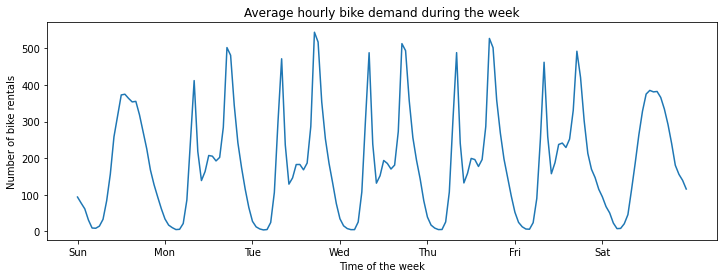

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

## 2 Using time dependent target data in a regression problem

**Note:** The code for this part of the notebook has been adapted from this [tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html). The orginal tutorial has far more examples of time series feature engineering, so take a look at it if you are interested. In this section we will be looking exclusively at the tree-based regression analysis using [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting). Our goal in this section is to properly deal with target data that has a time-dependent component to it. 

Gradient Boosting Regression is an **ensemble machine learning technique** used to make predictions. It combines multiple weak models (such as decision trees) to form a more powerful model. The idea behind this method is to iteratively add models to correct the errors made by previous models until a satisfactory prediction is achieved. The method adjusts the parameters of each successive model based on the gradient of the loss function. You will learn the math behind this adjustment (called gradient descent) later on when you start learning about neural networks.

To demonstrate this regression, we will be using the bike sales dataset above. The target variable in this case is the number of bike rentals. Let us inspect this dataset.

In [8]:
df.head() 

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   year        17379 non-null  float64 
 2   month       17379 non-null  float64 
 3   hour        17379 non-null  float64 
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  float64 
 6   workingday  17379 non-null  category
 7   weather     17379 non-null  category
 8   temp        17379 non-null  float64 
 9   feel_temp   17379 non-null  float64 
 10  humidity    17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  count       17379 non-null  float64 
dtypes: category(4), float64(9)
memory usage: 1.3 MB


In [10]:
df.describe()

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


 We will first do a little data preprocessing on this dataset.

1. We will rescale the target variable from a number to a fraction of the maximum bike sales, so that the mean absolute error is more easily interpreted as a fraction of the maximum demand.
2. We will combine the "heavy rain" and "rain" categories into a single category in the "weather" column.

In [11]:
y = df["count"] / df["count"].max()

X = df.drop("count", axis="columns")
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

### 2.1 Time-based cross-validation

TimeSeriesSplit is a class in the scikit-learn library that can be used to split time series data into training and validation sets for model evaluation. The main difference between TimeSeriesSplit and other data splitting methods in scikit-learn, such as train_test_split or KFold, is that TimeSeriesSplit takes into account the temporal nature of time series data.

In TimeSeriesSplit, the data is split into training and validation sets by using contiguous blocks of time, instead of random samples. For example, consider a time series with 100 data points. If n_splits=3, then the first split will use the first 67 data points for training and the last 33 data points for validation. The second split will use the first 33 data points from the first split and the next 33 data points from the original time series for training, and the remaining data points for validation. This process is repeated for the specified number of splits.

In [12]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

### 2.2 Feature engineering

What is the difference between data preprocessing and feature engineering? Data preprocessing refers to the steps taken to clean and prepare the raw data for analysis. This may include tasks such as missing value imputation, scaling, normalization, and encoding categorical variables.

Feature engineering is the process of creating new features or modifying existing features from the preprocessed data to improve the performance of machine learning algorithms. This may involve combining multiple features, creating new features based on domain knowledge, or transforming features to better represent the underlying data.

In summary, data preprocessing is focused on cleaning and transforming the raw data, while feature engineering is focused on creating new and more useful representations of that data.

To perform feature engineering on this dataset, we will use the scikit learn pipeline functionality. We will use this pipeline to convert our categorical variables into categorical columns. (Note: you can also do this with get_dummies in pandas).

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate


categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)


gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
)

# .set_output(transform="pandas")

### 2.3 Evaluating the model

In [15]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )
    
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     nan +/- nan
Root Mean Squared Error: nan +/- nan


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 256, in fit
    self.is_categorical_, known_categories = s

As we can see, with gradient boosting on tree-based models, we get an average error around 4 to 5% of the maximum demand, which is quite a decent result!

## 3 Decomposing a time series into trend, seasonality, and residuals

In the previous section, we saw an example of a regression with a time-dependent outcome/target variable. Time series regression, on the other hand, is a type of machine learning problem where the goal is to predict a continuous variable **based on time series data**. For example, given a time series of housing prices, the task could be to predict the housing prices for the next month. The output of a time series regression model is a continuous variable, such as a price or a number.

Similarly time series classification, is a type of machine learning problem where the goal is to predict a categorical variable based on time series data. For example, given a time series of stock prices, the task could be to predict whether the stock will go up or down in the next day. The output of a time series classification model is a categorical variable, such as "up" or "down".

In both of these cases, the input or feature variable is a time series. In order to extract useful information from the time series input, it may be necessary to break the series down into specific components, and use either the individual components or a mix of them for forecasting or classification.

A time series can be broken down into the following components:
1. **Trend:** The trend component of a time series is its long-term structure. It represents the underlying progression of the data, without the effects of seasonality and residual fluctuations. To estimate the trend, the function uses a moving average, which is calculated by taking the average of a certain number of data points centered around a given point in the time series. The length of the moving average window is determined by the frequency of the data.

2. **Seasonal:** The seasonal component of a time series represents regular fluctuations at a fixed frequency, such as daily, weekly, or monthly patterns. To estimate the seasonal component, the function first splits the time series into subseries, each containing one full cycle of the seasonal frequency. Then, for each subseries, it calculates the average of the data points in that subseries. The resulting average values represent the seasonal component of the time series.

3. **Residual:** The residual component of a time series represents random fluctuations that cannot be explained by the trend and seasonal components. To calculate the residual component, the function subtracts the estimated trend and seasonal components from the original time series. The resulting residuals represent the remaining fluctuations in the data that are not explained by the trend and seasonal components.

### 3.1 Decomposition using the statsmodels library

For this code to work, you need to install the [statsmodels](https://www.statsmodels.org/stable/index.html) library in your working environment using pip install statsmodels.

The statsmodels.tsa.seasonal_decompose function performs a seasonal decomposition of time series data using moving averages. The decomposition separates the time series into three components: trend, seasonal, and residual. The idea is that the trend represents the underlying structure of the time series, while the seasonal component represents regular fluctuations at a fixed frequency, and the residual component represents random fluctuations that cannot be explained by the trend and seasonal components.

The true time series is then the sum of the trend, seasonal, and residual components. $y_t = S_t + T_t + R_T$

where $y_T$ is the data, $s_T$ is the seasonal component, $T_t$is the trend-cycle component, and $R_t$ is the remainder component, all at period $t$.

In [ ]:
import statsmodels.api as sm

def decompose_ts(series, period=None):
    result = sm.tsa.seasonal_decompose(series, period=period)
    return result.trend, result.seasonal, result.resid

time_index = np.arange(0, len(average_week_demand))
trend, seasonal, resid = decompose_ts(average_week_demand, period=24)

For this section of the notebook we will be using a dataset on global temperature, averaged per month.

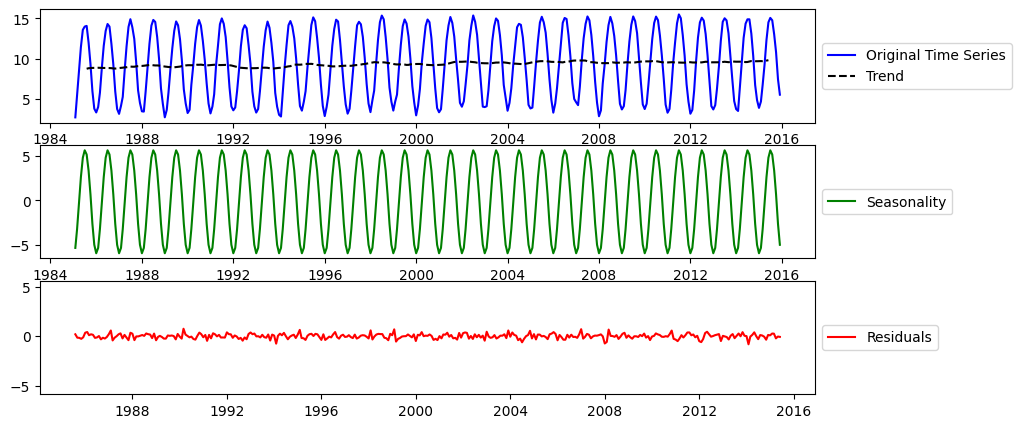

In [ ]:
# Read dataset
temp_df = pd.read_csv("GlobalTemperatures.csv")

# Convert date column to pandas date type
temp_df["Date"] = pd.to_datetime(temp_df['dt'], format='%Y-%m-%d')

# Drop unused columns
temp_df = temp_df.drop(["dt", "LandAverageTemperatureUncertainty", "LandMaxTemperature", "LandMaxTemperatureUncertainty", "LandMinTemperature", "LandMinTemperatureUncertainty",
                       "LandAndOceanAverageTemperature", "LandAndOceanAverageTemperatureUncertainty"], axis="columns")

# Extract data from the year 1985 onward
recent_data = temp_df[temp_df["Date"] > '1985-01-01']

# Decompose the time series
time_index = recent_data["Date"]
trend, seasonal, resid = decompose_ts(recent_data["LandAverageTemperature"], period=12)

# Plot the time series
plt.figure(figsize=(10,5))
plt.subplot(3, 1, 1)
plt.plot(time_index, recent_data["LandAverageTemperature"], label="Original Time Series", color="blue")
plt.plot(time_index, trend, label="Trend", color="black", linestyle="dashed")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3, 1, 2)
plt.plot(time_index, seasonal, label="Seasonality", color="green")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3, 1, 3)
plt.plot(time_index, resid, label="Residuals", color="red")
plt.ylim(seasonal.min(), seasonal.max())
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

Let us take a closer look at the trend line. What do we see happening to the temperature over the past 3 decades? A rise of approximately $1^{\circ}$ in global average temperature. We also see a lot of fluctuations in the trend. What could be causing this?

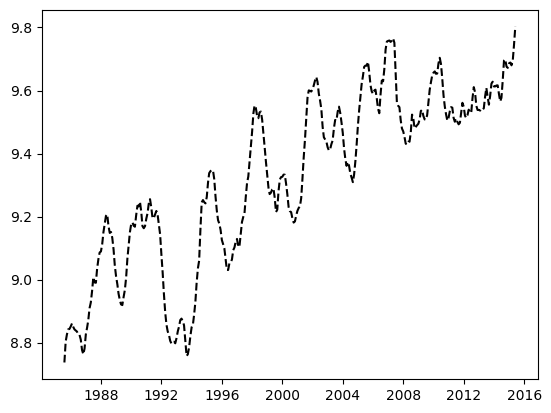

In [ ]:
plt.plot(time_index, trend, label="Trend", color="black", linestyle="dashed")

### 3.2 Decomposition math: moving average smoothing

The very first step in a time series decomposition is estimating the trend using moving average smoothing. The idea is simple - if you know the periodicity of the seasonal components, you can remove the seasonal variations by taking the average of the time series within a moving window of the period length. So for our example of the global temperature timeseries, we see a 12 month period of seasonal fluctuations, so we take a moving average of 12 to smooth it out. Mathematically speaking, $T_t = \frac{1}{m}\sum_{j=-k}^{k}y_{t+j}$ where $m = 2k + 1$. That is, the estimate of the trend-cycle at time $t$ is obtained by averaging values of the time series within $k$ periods of $t$.

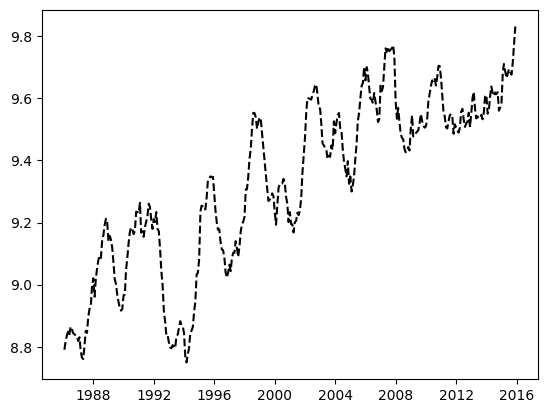

In [ ]:
trend_calculated = recent_data["LandAverageTemperature"].rolling(12, min_periods=1).mean()

# Since we use a rolling window of length 12, we should delete the first 12 values of our rolling mean
# We do this by setting them to NAN

trend_calculated[:12] = float("nan")

plt.plot(time_index, trend_calculated, label="Trend", color="black", linestyle="dashed")

### 3.3 Decomposition math: seasonal component estimation

Once we have the trend component, we can subtract it from the overall time series to get the de-trended series. From this de-trended series, simply average the detrended values for each season. For example, with our temperature data, the seasonal component is the average of all the detrended values for each year in the data. These seasonal component values are then adjusted to ensure that they average to zero. The seasonal component is obtained by stringing together the averaged values for each year, and then replicating the sequence for the entire duration of the timeseries.

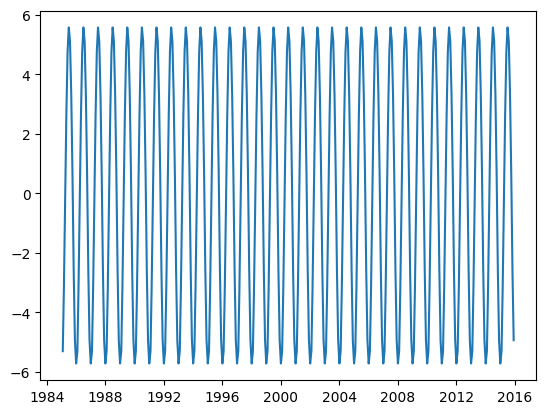

In [ ]:
# Subtract trend from original series
detrended = recent_data["LandAverageTemperature"] - trend_calculated

# Split the detrended data into chunks, equal to the seasonal length

# First we get the indices where to split, that is where the year changes
indices = (time_index.dt.year.diff() != 0).to_numpy().nonzero()[0]

# Now split the data
seasonal_chunks = np.split(detrended, indices)[2:] # The first two chunks do not contain 12 months of datapoints

# Take the average of all the chunks, make sure nan values are removed
seasonal_average = np.mean(np.nan_to_num(seasonal_chunks), axis=0)

# Adjust the seasonal component to be centered at zero
seasonal_average -= np.mean(seasonal_average)

# Replicate this for the entire timeseries
nyears = time_index.dt.year.nunique()
seasonal_calculated = pd.concat([pd.Series(seasonal_average)] * nyears)[1:]

# Plot results
plt.plot(time_index, seasonal_calculated, label="Seasonality")

## 4 Analysing periodic components (frequency components) using a Fourier analysis

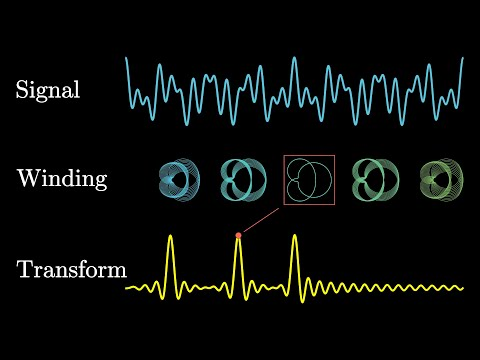

In [ ]:
YouTubeVideo("spUNpyF58BY", width=800, height=500)

The Fourier analysis is a mathematical method that breaks down a time series into its constituent frequencies. It is used to identify the underlying patterns in a time series and to understand how different frequencies contribute to the overall behavior of the series.

Here's the most important thing you need to know about Fourier analysis: **any time series** can be decomposed into a series of sin and cos functions:

$f(t) = \frac{a_0}{2} + \sum_{k=1}^{\infty}(a_k\cos(2\pi kt) + b_k\sin(2\pi kt))$.

Here, $a_0$, $a_k$, and $b_k$ are coefficients corresponding to the constant component, the cosine components, and the sine components respectively. This is not very intuitive to think about, but it is mathematically true! Here is an example of a square-wave being constructed from several sin and cos functions:
![Square wave](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Fourier_series_for_square_wave.gif/350px-Fourier_series_for_square_wave.gif)

Use the **Fourier transform** to find the frequencies of the sine and cosine waves in the time series. The Fourier transform is a mathematical tool that finds the frequencies of the waves in a series of complex numbers.

Plot the magnitude of each frequency as a function of frequency to see which frequencies contribute the most to the overall behavior of the time series. The magnitude is a measure of how much each frequency contributes to the time series. If certain frequencies have a very high magnitude, it means they are contributing significantly to the time series. If they have low magnitudes, they are probably not very important, and can be ignored. (Does this remind you of Principal Component Analysis?)

Use the inverse Fourier transform to convert the frequencies back into a time series. This gives you a representation of the time series in terms of its constituent frequencies.

Use the information from the Fourier analysis to make predictions or to understand the underlying patterns in the time series.

It's important to note that Fourier analysis is most effective when the time series is periodic, which means that it repeats itself over a set period of time. However, many real-world time series are not perfectly periodic, so additional techniques may need to be applied to make the Fourier analysis more accurate.

In the example below, we will create an additive mixture of periodic signals and use the Fourier transform to extract the individual periodic components:

Text(0.5, 1.0, 'Second periodic component')

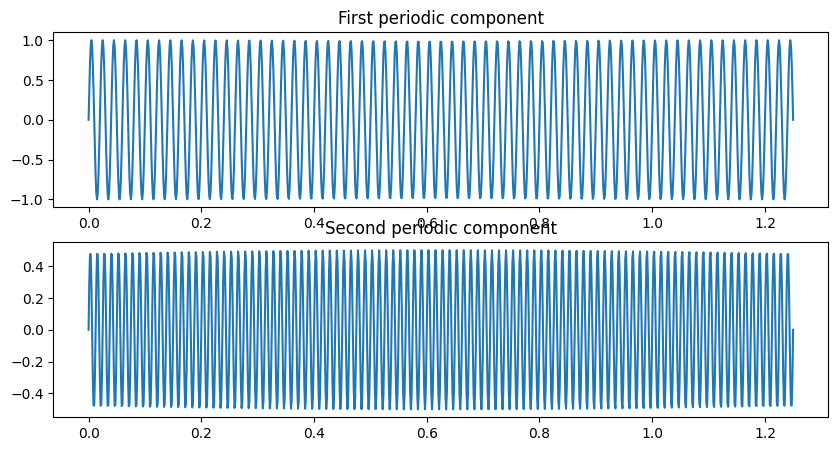

In [ ]:
# Number of samples in our time series
N = 1000

# Sample rate - this will give the max range of frequencies to decompose into
T = 1.0 / 800.0

# Generate time values
t = np.linspace(0.0, N*T, N)

# Generate two sinuoidal waves
s1 = np.sin(50.0 * 2.0*np.pi*t) # This wave has a freuency 50 hertz, so it vibrates 50 times per time unit
s2 = 0.5*np.sin(80.0 * 2.0*np.pi*t) # This wave has a freuency 80 hertz, so it vibrates 50 times per time unit

# Plot the individual sine waves
plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
plt.plot(t, s1)
plt.title("First periodic component")
plt.subplot(2, 1, 2)
plt.plot(t, s2)
plt.title("Second periodic component")

What does it look like when these two components are added up?

Text(0.5, 1.0, 'Sum of two periodic components')

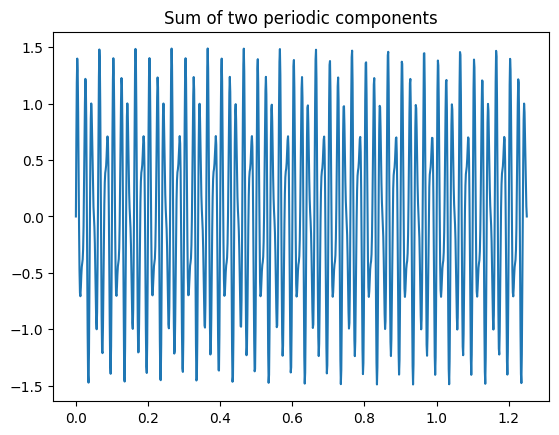

In [ ]:
# Generate a mixture of sinusoidal waves
mixture = s1 + s2 

# Plot the additive mixture
plt.plot(t, mixture)
plt.title("Sum of two periodic components")

It is not very straightforward to tell that there are two sinusoidal components in here. Here is where the Fourier transform comes into the picture. We won't go into the math here, but we will use the np.fft.fft function to compute the Fourier transform of the mixture. This gives us the frequencies of the sinusoidal waves in the mixture. We then compute the magnitude of the frequencies using the np.abs function and the formula 2.0/N * np.abs(yf[:N//2]). This gives us a measure of how much each frequency contributes to the mixture.

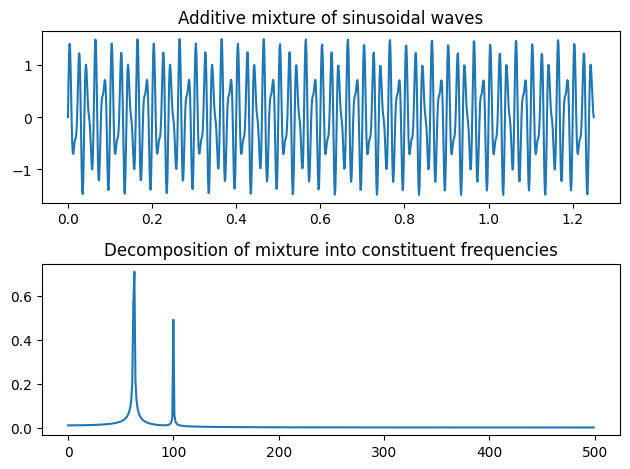

In [ ]:
# Compute the Fourier transform of the mixture
yf = np.fft.fft(mixture)

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(yf[:N//2])

# Plot the mixture and its constituent frequencies
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t, mixture)
ax1.set_title("Additive mixture of sinusoidal waves")

ax2.plot(magnitude)
ax2.set_title("Decomposition of mixture into constituent frequencies")

plt.tight_layout()
plt.show()

We clearly see here two peaks - one corresponding to the frequency of 50 (s1) and one corresponding to the frequency of 80 (s2). This is the case when the data is a pure mixture of periodic components. What if the time series data is noisy, or contains non-periodic components?

Text(0.5, 1.0, 'Second periodic component')

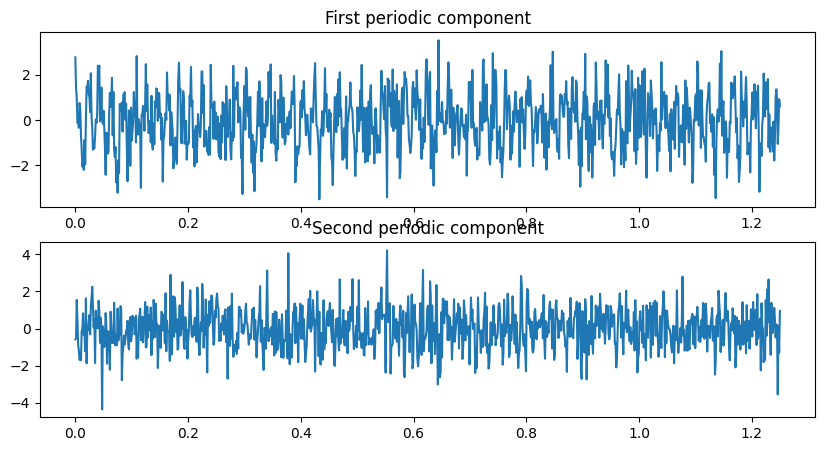

In [ ]:
s1_noisy = s1 + np.random.normal(0, 1, N)
s2_noisy = s2 + np.random.normal(0, 1, N)

# Plot the individual sine waves
plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
plt.plot(t, s1_noisy)
plt.title("First periodic component")
plt.subplot(2, 1, 2)
plt.plot(t, s2_noisy)
plt.title("Second periodic component")

And now we add them up and decompose the mixture:

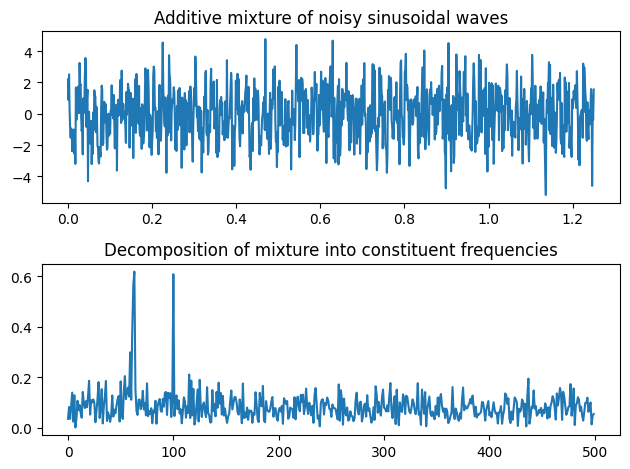

In [ ]:
mixture = s1_noisy + s2_noisy

# Compute the Fourier transform of the mixture
yf = np.fft.fft(mixture)

# Compute the magnitude of the frequencies
magnitude = 2.0/N * np.abs(yf[:N//2])

# Plot the mixture and its constituent frequencies
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t, mixture)
ax1.set_title("Additive mixture of noisy sinusoidal waves")

ax2.plot(magnitude)
ax2.set_title("Decomposition of mixture into constituent frequencies")

plt.tight_layout()
plt.show()

The resulting Fourier transform is a lot more noisy, but we can still easily identify the frequencies of the underlying periodic components s1 and s2.

## 5 Exercises

For the first few exercises you will be using the plastics dataset. The plastics data set consists of the monthly sales (in thousands) of a product for a plastics manufacturer for five years.

In [ ]:
plastics = pd.read_csv("PlasticSales.csv")

### Question 1: Inspect the dataset. Plot the time series of sales of the plastic product. Can you identify seasonal fluctuations and/or a trend-cycle?

In [ ]:
## Your code here



### Question 2: Use a time series decomposition to calculate the trend and seasonal components.

In [ ]:
## Your code here



### Question 3: Do the results support the graphical interpretation from part a?

In [ ]:
## Your code here



### Question 4: Compute and plot the seasonally adjusted data.

In [ ]:
## Your code here



### Question 5: Change one observation to be an outlier (e.g., add 500 to one observation), and recompute the seasonally adjusted data. What is the effect of the outlier?

In [ ]:
## Your code here



### Question 6: Does it make any difference if the outlier is near the end rather than in the middle of the time series?

In [ ]:
## Your code here



For the next few questions you will be using the [sunspot dataset](https://www.kaggle.com/datasets/robervalt/sunspots). Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. Sunspots are a good indicator of solar activity - more sunspots means more solar activity. They can therefore also be used to predict how much the sun affects the temperature of the earth.

In [ ]:
sunspots = pd.read_csv("Sunspots.csv", index_col=0)

# Convert date column to pandas date type
sunspots["Date"] = pd.to_datetime(sunspots['Date'], format='%Y-%m-%d')

### Question 7: Inspect the data. Plot the time series data of the sunspots. Do you notice a seasonal / periodic component?

In [ ]:
## Your code here



### Question 8: What is the unit of time measured in this dataset? How many time units in total have been recorded?

In [ ]:
## Your code here



### Question 9: Compute the Fourier transform of the time series.

In [ ]:
## Your code here



In [ ]:
3265/25

130.6

### Question 10: Do you notice any large magnitudes in the Fourier decomposition? What frequency or frequencies do they correspond to? (Hint: ignore the peak magnitude at frequency = 0, because this corresponds to the constant component)

In [ ]:
## Your code here



### Question 11: Now that you have the frequency of the peak contributing periodic component, and the unit of frequency in this case is 1 / (total time units), what is the time period of this component? 

In [ ]:
## Your code here



### Question 12: Convert the time period you just calculated into years. Round this to the nearest year.

In [ ]:
## Your code here



Finally, go back to the dataset of global average temperature. In this, we saw that the trend had a lot of fluctuations. It turns out that these fluctuations are caused by solar activity. So if we smooth out these fluctuations using the time period of the periodic solar activity, we should be able to see the true trend of global temperature rise!

### Question 13: Use the value calculated in the previous question to smooth the global average temperature trend using a moving average. Plot the smoothed trend. What does this tell you?

In [ ]:
## Your code here

